In [1]:
!pip install catboost


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 6.4 MB/s eta 0:00:00


In [2]:
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.9/190.9 MB 4.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.3.1+cu121 requires nvidia-cublas-cu12==12.1.3.1; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cuda-cupti-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cuda-nvrtc-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cuda-runtime-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cudnn-cu12==8.9.2.26; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requ

In [3]:
!pip install lightgbm

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from scipy import stats
import joblib
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt  # Import the necessary module
import seaborn as sns
import os


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
os.listdir('/content/drive/MyDrive/CI Assignment competition /playground-series-s4e4.zip (Unzipped Files)')

['sample_submission.csv', 'test.csv', 'train.csv']

In [7]:
# Load train and test data
train_df = pd.read_csv('/content/drive/MyDrive/CI Assignment competition /playground-series-s4e4.zip (Unzipped Files)/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/CI Assignment competition /playground-series-s4e4.zip (Unzipped Files)/test.csv')


In [8]:
train_df.shape

(90615, 10)

In [9]:
# Define the function to find outliers based on IQR
def find_outliers(df, column):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    IQR = q3 - q1
    upper_bound = q3 + 1.5 * IQR
    lower_bound = q1 - 1.5 * IQR
    return df[(df[column] < lower_bound) | (df[column] > upper_bound)]

# Define the function to remove outliers
def remove_outliers(df, column):
    outliers = find_outliers(df, column)
    df_clean = df[~df.index.isin(outliers.index)]
    return df_clean


# Define numerical columns to check for outliers
numerical_columns = ['Length', 'Diameter', 'Height', 'Whole weight', 'Whole weight.1', 'Whole weight.2', 'Shell weight']


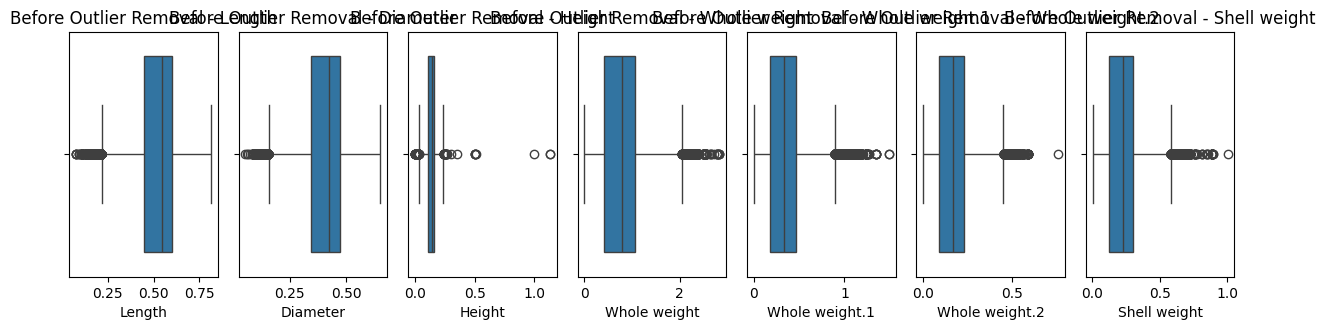

In [10]:
# Plot box plots for each numerical column before outlier removal
def plot_boxplots(df, columns, title):
    plt.figure(figsize=(12, 6))
    for i, col in enumerate(columns):
        plt.subplot(2, len(columns), i + 1)
        sns.boxplot(x=df[col])
        plt.title(f'{title} - {col}')
    plt.tight_layout()
    plt.show()
# Plot before outlier removal
plot_boxplots(train_df, numerical_columns, "Before Outlier Removal")

# Remove outliers for each numerical column
for col in numerical_columns:
    train_df = remove_outliers(train_df, col)



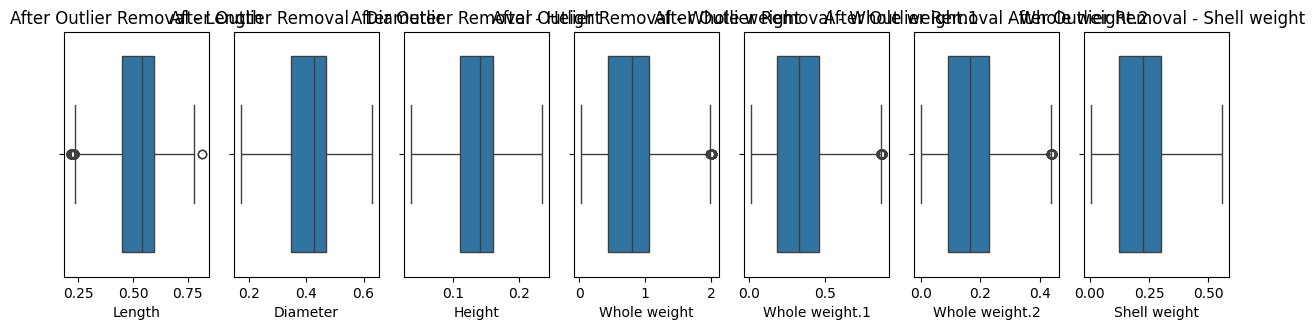

In [11]:
# Plot box plots for each numerical column after outlier removal
plot_boxplots(train_df, numerical_columns, "After Outlier Removal")

In [12]:
# Display the first few rows of the DataFrame
train_df.head()

,id,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
0,0,F,0.550,0.430,0.150,0.7715,0.3285,0.1465,0.2400,11
1,1,F,0.630,0.490,0.145,1.1300,0.4580,0.2765,0.3200,11
3,3,M,0.595,0.475,0.150,0.9145,0.3755,0.2055,0.2500,10
4,4,I,0.555,0.425,0.130,0.7820,0.3695,0.1600,0.1975,9
5,5,F,0.610,0.480,0.170,1.2010,0.5335,0.3135,0.3085,10


In [13]:
# Display the last raws
train_df.tail()

,id,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
90610,90610,M,0.335,0.235,0.075,0.1585,0.0685,0.0370,0.0450,6
90611,90611,M,0.555,0.425,0.150,0.8790,0.3865,0.1815,0.2400,9
90612,90612,I,0.435,0.330,0.095,0.3215,0.1510,0.0785,0.0815,6
90613,90613,I,0.345,0.270,0.075,0.2000,0.0980,0.0490,0.0700,6
90614,90614,I,0.425,0.325,0.100,0.3455,0.1525,0.0785,0.1050,8


In [14]:
train_df.shape


(86766, 10)

In [15]:
test_df.shape

(60411, 9)

In [16]:
# Check for missing values
train_df.isnull().sum()

,0
id,0
Sex,0
Length,0
Diameter,0
Height,0
Whole weight,0
Whole weight.1,0
Whole weight.2,0
Shell weight,0
Rings,0


In [17]:
# Check for duplicated values
duplicates = train_df.duplicated()

# Count the number of duplicated rows
num_duplicates = duplicates.sum()

print("Number of duplicated rows:", num_duplicates)

Number of duplicated rows: 0


<Axes: xlabel='Rings'>

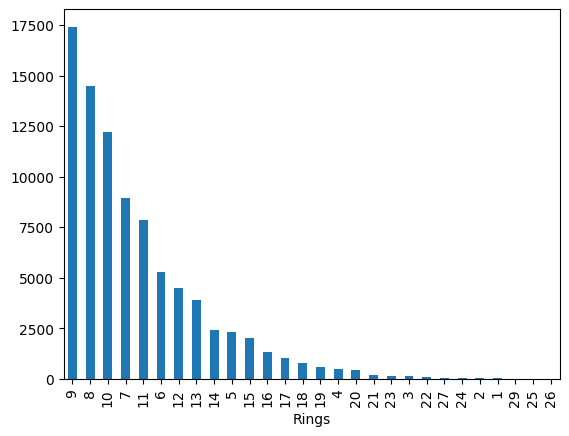

In [18]:
# Visualize the distribution of the target variable (Rings)

train_df['Rings'].value_counts().plot(kind='bar')

In [19]:
# Encode categorical variables

le = LabelEncoder()
train_df['Sex'] = le.fit_transform(train_df['Sex'])
test_df['Sex'] = le.transform(test_df['Sex'])

In [20]:
# Split data into features and target variable

X = train_df.drop(['id', 'Rings'], axis=1)
y = train_df['Rings']
X_test = test_df.drop('id', axis=1)

In [21]:
# Split data into train and validation sets

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 86766 entries, 0 to 90614
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              86766 non-null  int64  
 1   Sex             86766 non-null  int64  
 2   Length          86766 non-null  float64
 3   Diameter        86766 non-null  float64
 4   Height          86766 non-null  float64
 5   Whole weight    86766 non-null  float64
 6   Whole weight.1  86766 non-null  float64
 7   Whole weight.2  86766 non-null  float64
 8   Shell weight    86766 non-null  float64
 9   Rings           86766 non-null  int64  
dtypes: float64(7), int64(3)
memory usage: 7.3 MB


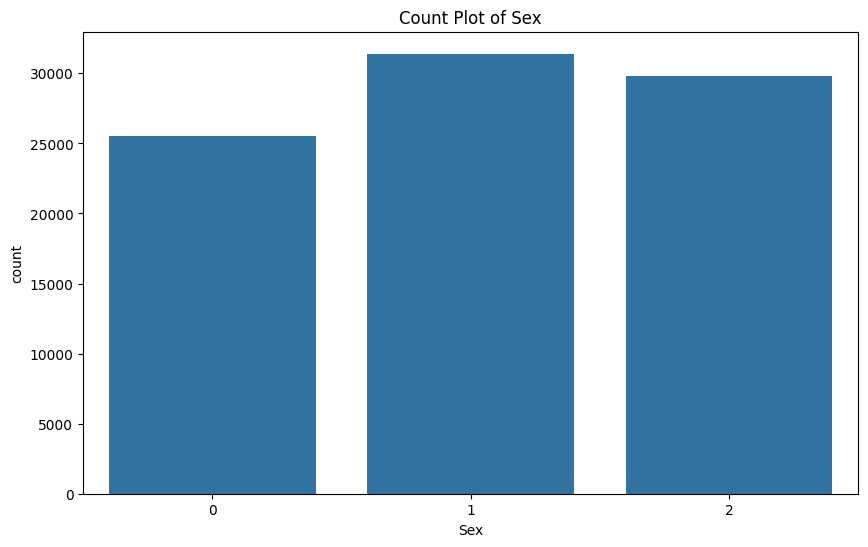

In [23]:
#data visualization
# Count Plot
plt.figure(figsize=(10, 6))
sns.countplot(x='Sex', data=train_df)
plt.title('Count Plot of Sex')
plt.show()


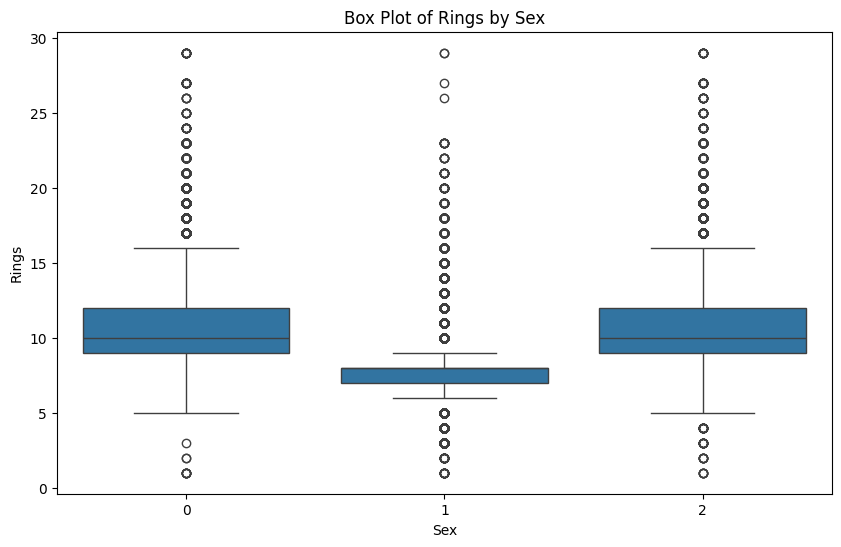

In [24]:
# Box Plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Sex', y='Rings', data=train_df)
plt.title('Box Plot of Rings by Sex')
plt.show()

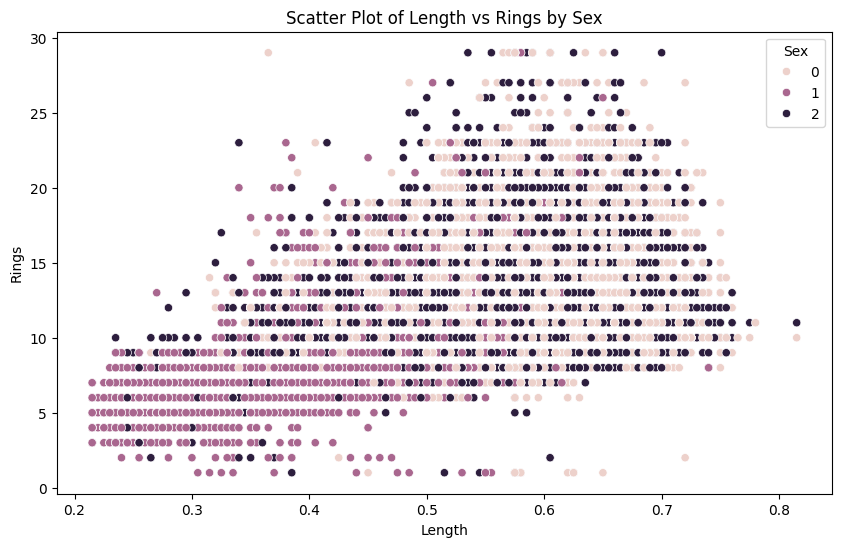

In [25]:
# Scatter Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Length', y='Rings', hue='Sex', data=train_df)
plt.title('Scatter Plot of Length vs Rings by Sex')
plt.show()


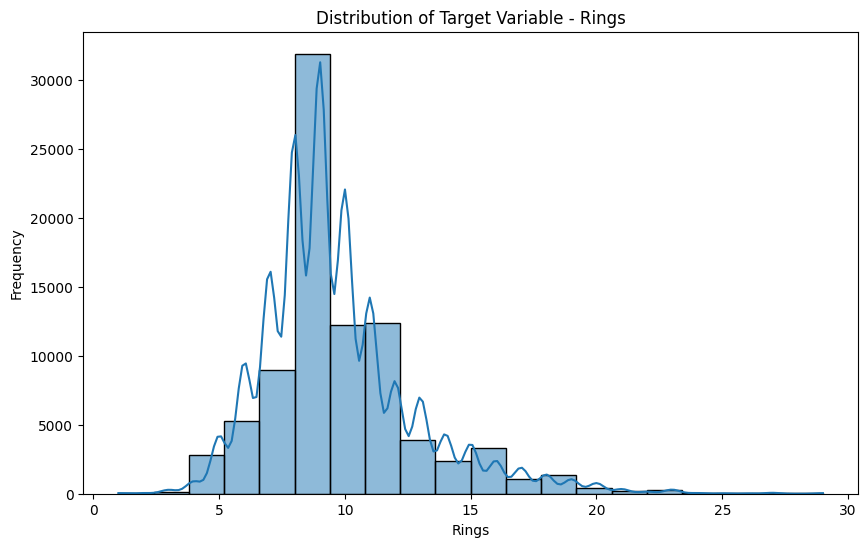

In [26]:
# Visualize the distribution of the target variable (Rings)
plt.figure(figsize=(10, 6))
sns.histplot(train_df['Rings'], bins=20, kde=True)
plt.title('Distribution of Target Variable - Rings')
plt.xlabel('Rings')
plt.ylabel('Frequency')
plt.show()


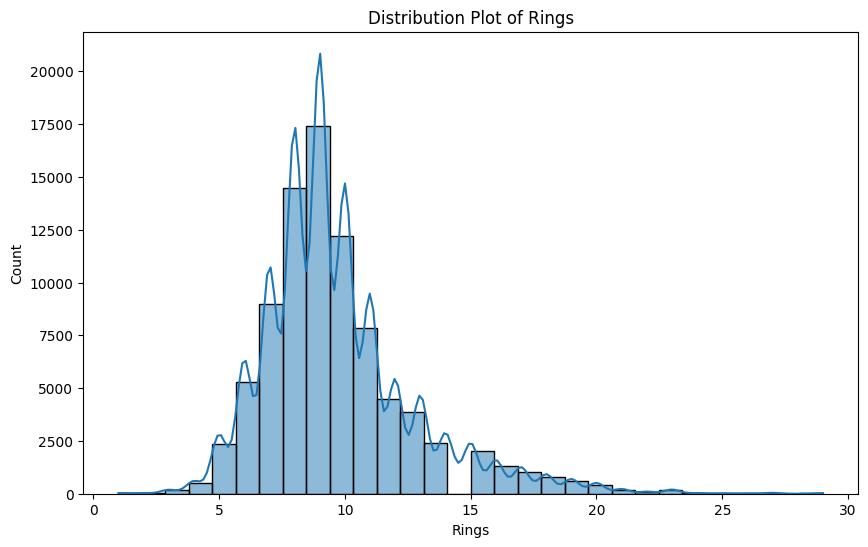

In [27]:
# Distribution Plot (Distplot)
plt.figure(figsize=(10, 6))
sns.histplot(train_df['Rings'], kde=True, bins=30)
plt.title('Distribution Plot of Rings')
plt.show()


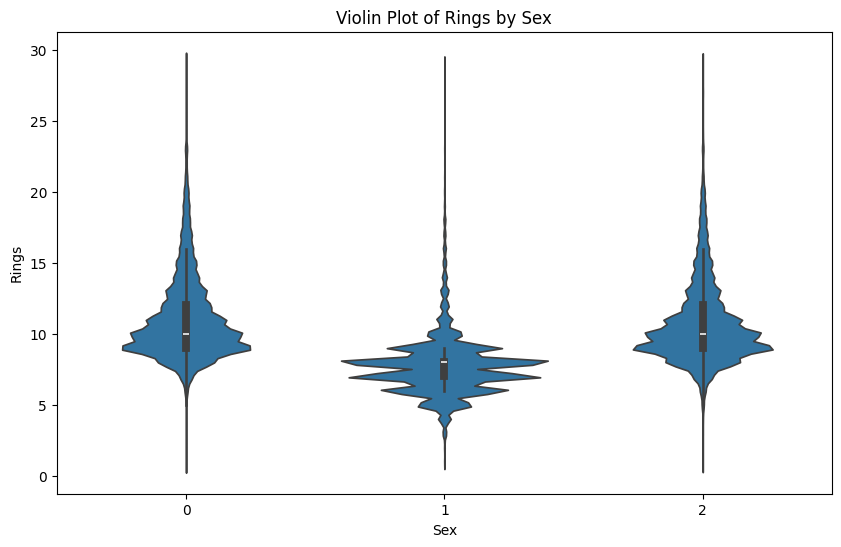

In [28]:
# Violin Plot
plt.figure(figsize=(10, 6))
sns.violinplot(x='Sex', y='Rings', data=train_df)
plt.title('Violin Plot of Rings by Sex')
plt.show()


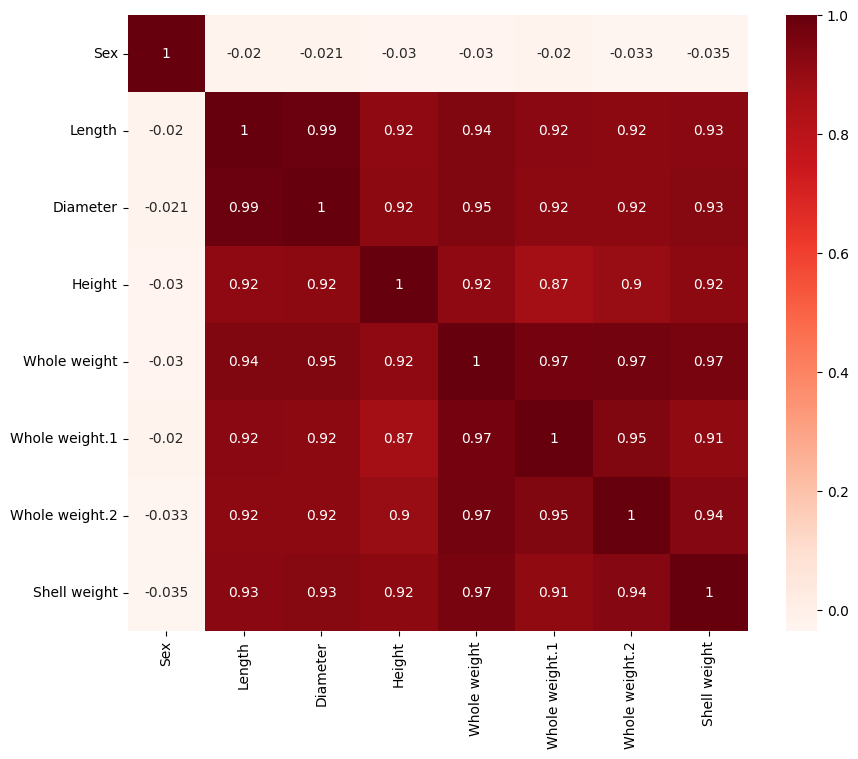

In [29]:
# Compute the correlation matrix
corr_matrix = X.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap=plt.cm.Reds)
plt.show()




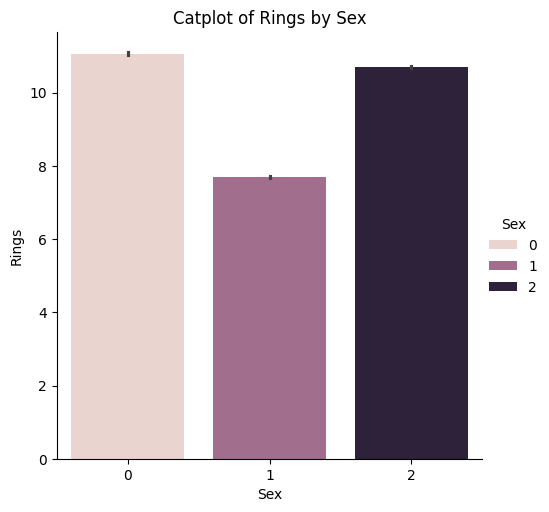

In [30]:
# Categorical Plot (Catplot)
sns.catplot(x='Sex', y='Rings', hue='Sex', kind='bar', data=train_df)
plt.title('Catplot of Rings by Sex')
plt.show()

In [31]:
# Feature selection using Recursive Feature Elimination (RFE)
model_for_rfe = RandomForestRegressor(random_state=42)
rfe = RFE(estimator=model_for_rfe, n_features_to_select=10, step=1)
X_train_selected = rfe.fit_transform(X_train, y_train)
X_val_selected = rfe.transform(X_val)
X_test_selected = rfe.transform(X_test)

selected_features = X.columns[rfe.get_support(indices=True)]
print("Selected features:", selected_features)

Selected features: Index(['Sex', 'Length', 'Diameter', 'Height', 'Whole weight', 'Whole weight.1',
       'Whole weight.2', 'Shell weight'],
      dtype='object')


In [33]:
from sklearn.ensemble import RandomForestRegressor


In [34]:

# Train a RandomForest model
model = RandomForestRegressor()
model.fit(X, y)

# Get feature importances
importances = model.feature_importances_
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

print("Feature importances:\n", feature_importances)

# Select top n features
top_n_features = feature_importances['Feature'][:10]
X_selected = X[top_n_features]


Feature importances:
           Feature  Importance
7    Shell weight    0.548022
5  Whole weight.1    0.155354
4    Whole weight    0.081103
6  Whole weight.2    0.071088
1          Length    0.045465
3          Height    0.043695
2        Diameter    0.040974
0             Sex    0.014299


In [35]:
# Define custom RMSLE scorer
def rmsle_score(y_true, y_pred):
    y_true = np.maximum(y_true, 0)
    y_pred = np.maximum(y_pred, 0)
    squared_log_errors = (np.log1p(y_pred) - np.log1p(y_true)) ** 2
    mean_squared_log_error = np.mean(squared_log_errors)
    rmsle = np.sqrt(mean_squared_log_error)
    return rmsle


In [36]:
rmsle_scorer = make_scorer(rmsle_score, greater_is_better=False)

In [54]:
 #Hyperparameter tuning with additional models
param_grids = {
    'RandomForestRegressor': {
        'n_estimators': [100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5],
    },
    'XGBRegressor': {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 6],
    },
    'CatBoostRegressor': {
        'iterations': [100, 200],
        'depth': [4, 6],
        'learning_rate': [0.01, 0.1],
    },
    'LGBMRegressor': {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1],
        'num_leaves': [31, 40],
    },

    'DecisionTreeRegressor': {
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5],
    },

    'GradientBoostingRegressor': {
        'max_depth': [10, 20, 30],
        'min_samples_split': [10, 20],
        'min_samples_leaf': [5, 10],
    },
    'SVR': {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf'],
        'epsilon': [0.01, 0.1],
    }
}

In [45]:
models = [
    RandomForestRegressor(random_state=42),
    XGBRegressor(random_state=42),
    CatBoostRegressor(verbose=0, random_state=42),
    LGBMRegressor(random_state=42),
    DecisionTreeRegressor(random_state=42),
    GradientBoostingRegressor(random_state=42),
    SVR()
]

In [46]:
# Track best model and its RMSLE score
best_model = None
best_model_name = ""
best_rmsle = float('inf')

for model in models:
    model_name = model.__class__.__name__

    if model_name in param_grids:
        grid_search = GridSearchCV(model, param_grids[model_name], scoring=rmsle_scorer, cv=3, n_jobs=-1, verbose=1)
        grid_search.fit(X_train, y_train)
        model_best = grid_search.best_estimator_
        model_best_rmsle = grid_search.best_score_
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        model_best_rmsle = rmsle_score(y_val, y_pred)
        model_best = model

    print(f"{model_name}: Best RMSLE: {model_best_rmsle}")

    if model_best_rmsle < best_rmsle:
        best_model = model_best
        best_rmsle = model_best_rmsle
        best_model_name = model_name

print(f"Best model: {best_model_name} with RMSLE: {best_rmsle}")

Fitting 3 folds for each of 12 candidates, totalling 36 fits
RandomForestRegressor: Best RMSLE: -0.1510408034449429
Fitting 3 folds for each of 8 candidates, totalling 24 fits
XGBRegressor: Best RMSLE: -0.14988891215668718
Fitting 3 folds for each of 8 candidates, totalling 24 fits
CatBoostRegressor: Best RMSLE: -0.15078561726249104
Fitting 3 folds for each of 8 candidates, totalling 24 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006056 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1262
[LightGBM] [Info] Number of data points in the train set: 69412, number of used features: 8
[LightGBM] [Info] Start training from score 9.712154
LGBMRegressor: Best RMSLE: -0.14946978678088926
DecisionTreeRegressor: Best RMSLE: 0.21477433287753012
Fitting 3 folds for each of 12 candidates, totalling 36 fits
GradientBoostingRegr

In [47]:
# Train the best performing model on full data
best_model.fit(X, y)

SVR(C=10)

In [48]:
model.get_params()

{'C': 1.0,
 'cache_size': 200,
 'coef0': 0.0,
 'degree': 3,
 'epsilon': 0.1,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [49]:
# Save the best model using joblib
joblib.dump(best_model, 'save_model14')

['save_model14']

In [50]:
# Prediction
predictions = best_model.predict(X_test)

In [51]:
# Prepare submission file
submission_df = pd.DataFrame({'id': test_df['id'], 'Rings': predictions})
submission_df.to_csv('submission14.csv', index=False)

In [52]:
train_df.columns

Index(['id', 'Sex', 'Length', 'Diameter', 'Height', 'Whole weight',
       'Whole weight.1', 'Whole weight.2', 'Shell weight', 'Rings'],
      dtype='object')

In [53]:
# view prediction
# Load the saved model
import joblib
best_model = joblib.load('save_model14')

# Prepare a dataframe with the features for prediction
# Example Data
data = {'Sex': ['Female'],
        'Length': [0.455],
        'Diameter': [0.365],
        'Height': [0.095],
        'Whole weight': [0.514],
        'Whole weight.1': [0.2245],
        'Whole weight.2': [0.101],
        'Shell weight': [0.15]}
predict_df = pd.DataFrame(data)

# Encode categorical variables
le = LabelEncoder()
predict_df['Sex'] = le.fit_transform(predict_df['Sex'])

# Make prediction
prediction = best_model.predict(predict_df)

print("Predicted Rings:", prediction)

Predicted Rings: [8.53582268]
